In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Define actions

In [2]:
def flip_pattern(pattern):
    return np.ascontiguousarray(np.flip(pattern))

def flip_S(S):
    return np.array([-S[2], S[1], -S[0]])

def shift_pattern(pattern, shift):
    return np.ascontiguousarray(np.roll(pattern, shift))

def shift_S(S, shift):
    return np.exp(2 * np.pi * 1j * np.array((-1, 0, 1)) * shift / 32) * S

# Load dataset

In [3]:
class GratingDataset(Dataset):
    def __init__(self, data_dict, augment=False):

        self.pattern    = np.copy(data_dict["pattern"].astype(np.float32))
        self.S          = np.copy(data_dict["S_inplane"][:,5:8].astype(np.complex64))

        self.augment = augment

        assert self.pattern.shape[0] == self.S.shape[0]
        self.size  = self.pattern.shape[0]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):

        pattern    = self.pattern[idx]
        S          = self.S[idx]

        if self.augment:
            # Random reflection
            if np.random.rand() > 0.5:
                pattern  = flip_pattern(pattern)
                S        = flip_S(S)

            # Random shift
            shift = np.random.randint(0, 32)
            pattern = shift_pattern(pattern, shift)
            S       = shift_S(S, shift)

        return pattern, S
    
# Load data dictionaries
train_data_dict = np.load("dataset/train.npz")
test_data_dict = np.load("dataset/test.npz")

# Split training data into training and validation
train_dataset = GratingDataset({
    "pattern": train_data_dict["pattern"][:20000],
    "S_inplane": train_data_dict["S_inplane"][:20000]
})
val_dataset = GratingDataset({
    "pattern": train_data_dict["pattern"][20000:],
    "S_inplane": train_data_dict["S_inplane"][20000:]
})

# Create test dataset
test_dataset = GratingDataset(test_data_dict)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

print("Number of training samples:", len(train_dataloader.dataset))
print("Number of validation samples:", len(val_dataloader.dataset))
print("Number of testing samples:", len(test_dataloader.dataset))

Number of training samples: 20000
Number of validation samples: 4000
Number of testing samples: 4000


# Build Models

### Standard MLP

In [4]:
class MLP(nn.Module):
    def __init__(self, width=277, hidden_layers=8, batch_norm=True):
        super().__init__()

        self.width = width
        self.hidden_layers = hidden_layers
        self.batch_norm = batch_norm

        layers = []

        layers.append(nn.Linear(32, width))
        layers.append(nn.ReLU())

        for i in range(hidden_layers-1):
            if batch_norm: layers.append(nn.BatchNorm1d(width))
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
            
        self.net = nn.Sequential(*layers)

        self.out_re = nn.Linear(width, 3)
        self.out_im = nn.Linear(width, 3)

    def forward(self, x):
        x = x * 2 - 1
        x = self.net(x)
        return torch.complex(self.out_re(x), self.out_im(x))

### Standard CNN

In [5]:
class CNN(nn.Module):
    def __init__(self, channels=128, poolings=2, convs_per_resolution=4, batch_norm=True):
        super().__init__()

        self.channels             = channels
        self.poolings             = poolings
        self.convs_per_resolution = convs_per_resolution
        self.batch_norm           = batch_norm

        # Valid number of poolings to get an output of shape between 1 and 32
        assert self.poolings in [0, 1, 2, 3, 4, 5]

        layers = []

        # Before first pooling
        for j in range(convs_per_resolution):
            if j != 0 and self.batch_norm: layers.append(nn.BatchNorm1d(self.channels))
            if j == 0: layers.append(nn.Conv1d(1, self.channels, 3, padding=1, padding_mode="zeros"))
            else:      layers.append(nn.Conv1d(self.channels, self.channels, 3, padding=1, padding_mode="zeros"))
            layers.append(nn.ReLU())

        # First pooling and beyond
        for i in range(self.poolings):
            layers.append(nn.AvgPool1d(2)),
            for j in range(convs_per_resolution):
                if self.batch_norm: layers.append(nn.BatchNorm1d(self.channels))
                layers.append(nn.Conv1d(self.channels, self.channels, 3, padding=1, padding_mode="zeros"))
                layers.append(nn.ReLU())

        # Flattening of final feature fields
        output_resolution = int(32 / (2**self.poolings))
        layers.append(nn.Flatten())
        flattened_features = self.channels * output_resolution

        self.net = nn.Sequential(*layers)

        # Output layers
        self.out_re = nn.Linear(flattened_features, 3)
        self.out_im = nn.Linear(flattened_features, 3)

    def forward(self, x):
        x = x[:,None,:] * 2 - 1
        x = self.net(x)
        return torch.complex(self.out_re(x), self.out_im(x))

### Equivariant CNN

In [ ]:
from ecnn1d import GConv1d

class EquivariantCNN(nn.Module):
    def __init__(self, hidden_feature_fields=64, poolings=2, convs_per_resolution=4, batch_norm=True):
        super().__init__()

        self.hidden_feature_fields  = hidden_feature_fields
        self.poolings               = poolings
        self.convs_per_resolution   = convs_per_resolution
        self.batch_norm             = batch_norm

        # Define how feature fields should transform under action of reflection

        # Represention for design (d is a scalar field --> trivial representation)
        self.input_repr = np.array([
            [1]
        ])

        # Representation for the hidden fields (regular representation)
        self.hidden_repr = np.array([
            [0, 1],
            [1, 0]
        ])

        # Representation for the scattering paramters (derived in paper)
        self.output_repr = np.array([
            [ 0, 0,-1],
            [ 0, 1, 0],
            [-1, 0, 0]
        ])

        # Register shift representation for the scattering parameters for use in 
        # the equivariant readout layer.

        # Output of CNN is feature field of shape (batch_size, S_length, spatial_dim).
        # To get shift equivariance, matrix multiply output features with this 
        # (S_length, S_length, spatial_dim) representation to get feature field of shape
        # (batch_size, S_length, spatial_dim), then average (integrate) over 
        # spatial dim to get result of shape (batch_size, S_length).
        n = torch.arange(32) + 0.5
        self.register_buffer("output_shift_repr", 
            torch.diag_embed(torch.stack((
                torch.exp(-1 * 2 * torch.pi * 1j * n / 32),
                torch.exp( 0 * 2 * torch.pi * 1j * n / 32),
                torch.exp( 1 * 2 * torch.pi * 1j * n / 32)
            ), dim=1), dim1=0, dim2=1)
        )

        # Define neural network layers
        layers = []

        # Original resolution
        for j in range(convs_per_resolution):
            # We use 2D batch normalization as an equivariant version of
            # 1D batch normalization. The group dimension is treated
            # as a second spatial dimension.
            if j != 0 and self.batch_norm: layers.append(nn.BatchNorm2d(self.hidden_feature_fields))
            if j == 0: # First layer
                layers.append(GConv1d(
                    1, self.hidden_feature_fields, 3, 
                    self.input_repr, self.hidden_repr, 
                    dilation=1, padding=1, padding_mode="circular"
                ))
            else:
                layers.append(GConv1d(
                    self.hidden_feature_fields, self.hidden_feature_fields, 3, 
                    self.hidden_repr, self.hidden_repr, 
                    dilation=1, padding=1, padding_mode="circular"
                ))
            layers.append(nn.ReLU())
                

        # Lower resolutions
        for i in range(self.poolings):
            dilation = 2**(i+1)
            for j in range(convs_per_resolution):
                if self.batch_norm: layers.append(nn.BatchNorm2d(self.hidden_feature_fields))
                layers.append(GConv1d(
                    self.hidden_feature_fields, self.hidden_feature_fields, 3, 
                    self.hidden_repr, self.hidden_repr, 
                    dilation=dilation, padding=dilation, padding_mode="circular"
                ))
                layers.append(nn.ReLU())
                

        self.net = nn.Sequential(*layers)

        # Output layers
        self.out_re = GConv1d(self.hidden_feature_fields, 1, 1, self.hidden_repr, self.output_repr, bias=False)
        self.out_im = GConv1d(self.hidden_feature_fields, 1, 1, self.hidden_repr, self.output_repr, bias=False)


    def forward(self, x):
        # The layers of the ECNN operator on tensors of the shape
        # (batch dim, channels, group_dimension, spatial_dimension])
        x = x[:,None,None,:] * 2 - 1                                # (None,1,1,32)
        x = self.net(x)                                             # (None,64,3,32)
        x = torch.complex(self.out_re(x), self.out_im(x))           # (None,1,3,32)
        x = x[:,0,:,:]                                              # (None,3,32)
        x = torch.einsum("ijk,bjk->bik", self.output_shift_repr, x) # (None,3,32)
        return torch.mean(x, dim=2)                                 # (None,3)

# Train models

### Generic train and test loops

In [7]:
import torch

def train_epoch(dataloader, model, loss_fn, optimizer, print_progress=True):
    size = len(dataloader.dataset)

    model.train()
    cumulative_loss   = 0
    processed_batches = 0
    for (x, t) in dataloader:
        x    = x.to(device)
        t    = t.to(device)

        optimizer.zero_grad(set_to_none=True)

        y = model(x)
        loss = loss_fn(y, t)

        loss.backward()

        optimizer.step()
        
        loss_val = loss.detach().item()
        cumulative_loss   += loss_val
        processed_batches += 1

        if print_progress:
            processed_samples = processed_batches * dataloader.batch_size
            print(f"loss: {loss_val:>10.5f}  [{processed_samples:>5d}/{size:>5d}]", end="\r")

    return cumulative_loss / processed_batches


def test_epoch(dataloader, model, loss_fn):

    cumulative_loss   = 0
    processed_batches = 0

    model.eval()
    with torch.no_grad():
        
        for x, t in dataloader:
            x    = x.to(device)
            t    = t.to(device)

            y = model(x)

            cumulative_loss += loss_fn(y, t).detach().item()
            processed_batches += 1

    return cumulative_loss / processed_batches

### Run training

In [8]:
# Select model here (MLP, MLP-A, CNN, CNN-A, or ECNN)
model_name = "ECNN"

if model_name == "MLP":
    model = MLP(hidden_layers=8, width=277, batch_norm=True).to(device)
    train_dataloader.dataset.augment = False
    lr, wd = 2.6e-3, 1.2e-7 # Optimized hyperparameters
elif model_name == "MLP-A":
    model = MLP(hidden_layers=8, width=277, batch_norm=True).to(device)
    train_dataloader.dataset.augment = True
    lr, wd = 1.6e-4, 1.1e-5
elif model_name == "CNN":
    model = CNN(channels=128, poolings=2, convs_per_resolution=4, batch_norm=True).to(device)
    train_dataloader.dataset.augment = False
    lr, wd = 9.4e-4, 8.9e-5
elif model_name == "CNN-A":
    model = CNN(channels=128, poolings=2, convs_per_resolution=4, batch_norm=True).to(device)
    train_dataloader.dataset.augment = True
    lr, wd = 6.4e-4, 4.2e-7
elif model_name == "ECNN":
    model = EquivariantCNN(hidden_feature_fields=64, poolings=2, convs_per_resolution=4, batch_norm=True).to(device)
    train_dataloader.dataset.augment = False
    lr, wd = 2.5e-3, 1.8e-7
else:
    raise Exception("Unknown model!")

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

# Define loss function
class MSE(nn.Module):
    def forward(self, y, t): return torch.mean(torch.square(torch.abs(y - t)))
loss_fn = MSE()

train_losses = []
val_losses = []
# 500 epochs were used to evaluate the models in the paper
for epoch in range(50):
    
    # Gradient step and validation
    train_loss = train_epoch(train_dataloader, model, loss_fn, optimizer, print_progress=True)
    val_loss  = test_epoch(val_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Print progress
    print(f"Epoch {epoch:>7} - train MSE: {train_loss:.5f} - val MSE: {val_loss:.5f}")

test_loss  = test_epoch(test_dataloader, model, loss_fn)
print(f"Test MSE: {test_loss:.5f}")



Epoch       0 - train MSE: 0.02155 - val MSE: 0.01392
Epoch       1 - train MSE: 0.01237 - val MSE: 0.01075
Epoch       2 - train MSE: 0.01019 - val MSE: 0.01061
Epoch       3 - train MSE: 0.00864 - val MSE: 0.00809
Epoch       4 - train MSE: 0.00725 - val MSE: 0.00682
Epoch       5 - train MSE: 0.00613 - val MSE: 0.00674
Epoch       6 - train MSE: 0.00530 - val MSE: 0.00501
Epoch       7 - train MSE: 0.00429 - val MSE: 0.00455
Epoch       8 - train MSE: 0.00398 - val MSE: 0.00485
Epoch       9 - train MSE: 0.00354 - val MSE: 0.00400
Epoch      10 - train MSE: 0.00333 - val MSE: 0.00343
Epoch      11 - train MSE: 0.00299 - val MSE: 0.00343
Epoch      12 - train MSE: 0.00292 - val MSE: 0.00366
Epoch      13 - train MSE: 0.00276 - val MSE: 0.00349
Epoch      14 - train MSE: 0.00290 - val MSE: 0.00295
Epoch      15 - train MSE: 0.00214 - val MSE: 0.00277
Epoch      16 - train MSE: 0.00214 - val MSE: 0.00257
Epoch      17 - train MSE: 0.00218 - val MSE: 0.00267
Epoch      18 - train MSE: 0

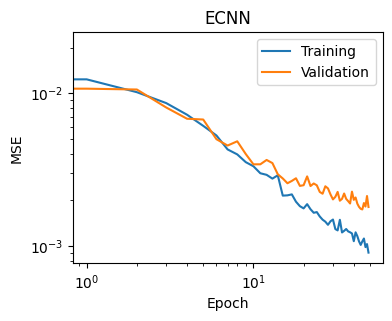

In [9]:
# Note: Validation loss may be slightly lower than training loss in the 
# beginning if batch norm is used, since the behaviour of this layer dependes 
# on if the model is in training or evaluation mode.

fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(train_losses, label="Training")
ax.plot(val_losses, label="Validation")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.set_title(model_name)
ax.legend()

# Inference

Design parameters:
[0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0.]


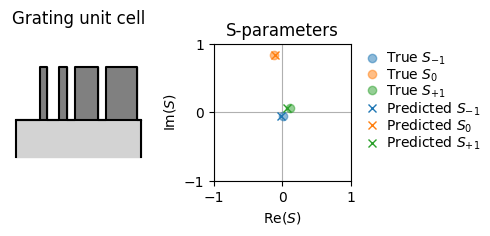

In [10]:
from parameterization import visualize

# Load a sample from the test set
sample_id = 0  # <-- Select sample here
design = test_dataloader.dataset.pattern[sample_id]
S_true = test_dataloader.dataset.S[sample_id]

# Predict scattering parameters of sample using trained model
model.eval()
with torch.no_grad():
    S_pred = model(torch.tensor(design).to(device)[None])[0].cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(5,2.5))

ax = axs[0]
ax.set_title("Grating unit cell")

visualize(ax, design)
print("Design parameters:")
print(design)


ax = axs[1]
ax.set_title("S-parameters")
ax.plot(np.real(S_true[0]), np.imag(S_true[0]), "C0o", label="True $S_{-1}$", alpha=0.5)
ax.plot(np.real(S_true[1]), np.imag(S_true[1]), "C1o", label="True $S_{0}$", alpha=0.5)
ax.plot(np.real(S_true[2]), np.imag(S_true[2]), "C2o", label="True $S_{+1}$", alpha=0.5)
ax.plot(np.real(S_pred[0]), np.imag(S_true[0]), "C0x", label="Predicted $S_{-1}$")
ax.plot(np.real(S_pred[1]), np.imag(S_true[1]), "C1x", label="Predicted $S_{0}$")
ax.plot(np.real(S_pred[2]), np.imag(S_true[2]), "C2x", label="Predicted $S_{+1}$")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.grid()
ax.set_xlabel("Re($S$)")
ax.set_ylabel("Im($S$)")
ax.set_aspect(1)
ax.legend(loc="upper left", bbox_to_anchor=(1,1), borderpad=0, frameon=False, labelspacing=0, handletextpad=0)

fig.tight_layout()
